# KKProject_9_Robustness

## Summary from last time:
- threshold equation found
- noticed that iForest algorithm fails on Ignacio's data (having been trained on Rohan's first)

## Aims and Objectives:
- Find cause for lack of robustness in iForest model (i.e. whether it's due to lack of data, or that the method used is flawed)
- Check for robustness of the threshold function, and make any necessary changes

## Notes:
- ought to ask Rohan if he's tried deploying the previous iForest algorithm or not



# Libraries

In [1]:
# file management
import os
import pickle

# mathematical
import numpy as np

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# modelling
from sklearn.ensemble import IsolationForest

# Data preparation

In [2]:
def directory_to_df(paths, exclude = [None], filetype = '.csv',ignore_index = True, exception = '_repet'):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    exclude: array of directories to excludes from the treatment
    filetype: a string of the file extension (must include .)
    ignore_index: boolean that tells pandas to ignore the index or not
    exception: takes a string. Any time a filename includes this string it is treated differently (for cases when you have
    more than one ) 
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    
    for path in paths:
        for filename in os.listdir(path):
            print(path)
            if filetype in filename and filename not in exclude:
                if exception in filename:
                    curr_df = pd.read_csv(path+filename)
                    curr_df = special_treatment(curr_df)
                    
                else:
                    curr_df = pd.read_csv(path+filename)                    
                frames.append(curr_df)
                filenames.append(filename.replace(filetype,''))
                for i in range(curr_df.shape[0]):
                    file_column.append(test_index)
                test_index+=1

    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames


def special_treatment(df):
    """ performs a custom operation on a dataframe
    components:
    df: dataframe to play on
    """
    columns = df.columns.values.tolist()
    columns.remove('date')
    df.drop('gyrZ',inplace = True, axis = 1)
    df.columns = columns
    df.reset_index(inplace = True)
    df.rename(columns= {'index':'date'},inplace = True)
    return df
    

In [3]:
base = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/{}'

paths = [base.format('Rohan/'),base.format('Ignacio/')]
df,filenames = directory_to_df(paths)

df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
print(df.shape)
df.head()

/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Ignacio/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Ignacio/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Ignacio/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Ignacio/
(58091, 10)


,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
0,2020-09-14 19:16:45,0.00,0.0,0.0,1.46,0.47,1.39,1,0.00,2.069928
1,2020-09-14 19:16:46,0.00,0.0,0.0,1.07,0.47,1.38,1,0.00,1.808369
2,2020-09-14 19:16:46,0.01,0.0,0.0,1.07,0.47,1.38,1,0.01,1.808369
3,2020-09-14 19:16:47,0.00,0.0,0.0,1.05,0.25,1.40,1,0.00,1.767767
4,2020-09-14 19:16:48,0.00,0.0,0.0,0.83,0.10,1.41,1,0.00,1.639207


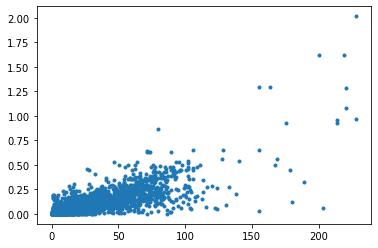

In [4]:
plt.plot(df.gyrTotal,df.accTotal,'.')

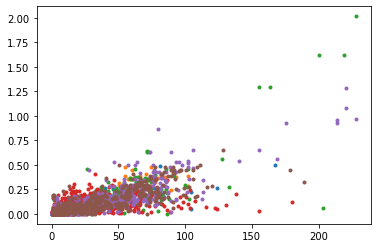

In [5]:
for i in df.files.unique():
    plt.plot(df.gyrTotal[df.files == i],df.accTotal[df.files == i],'.')

# there does not seem to be concerning variation... can proceed

## Robustness in iForest model

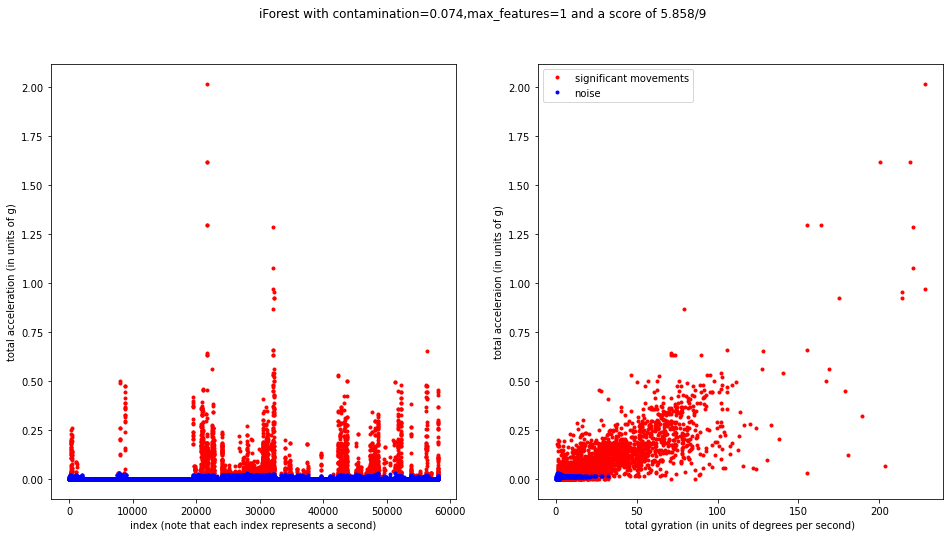

In [6]:
# old 'best' model
X = np.asarray(df[['gyrTotal','accTotal']])

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)

with open ('/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Models/iForest.pkl',"rb") as f:
    model = pickle.load(f)

output = model.predict(X_train)
true_false = []
                
for item in output:
    if item == 1:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]
                
plt.figure(figsize = (16,8))
plt.suptitle('iForest with contamination={},max_features={} and a score of {}/9'.format(0.074,1,5.858))            

plt.subplot(121)
plt.plot(anomalies.index,anomalies.accTotal,'r.')
plt.plot(actuals.index,actuals.accTotal,'b.')
plt.xlabel('index (note that each index represents a second)')
plt.ylabel('total acceleration (in units of g)')

plt.subplot(122)
plt.plot((anomalies.gyrTotal),(anomalies.accTotal),'r.')
plt.plot((actuals.gyrTotal),(actuals.accTotal),'b.')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])

plt.show()

# notes: model is OK, not entirely robust though

In [7]:
# perhaps it is best that we retrain the model
# recall the following

def findBestModel(X_train, X_test, Y_test, model='iForest'):
    """ Function to find the best parameters to use for a given model 
    components: 
    X_train: numpy array of the input data
    X_test: list containing numpy arrays of different test data
    Y_test: list containing numpy array of different test outcomes (note that this is configured differently 
    for different algorithms,for iForest, each column must have -1 or 1. -1 --> the anomaly, if 1 --> not an anomaly)
    model: string to determine model type
    """
    if model == 'iForest':
        total_score = 0;
        parameters = [0,0,0,0]
        for max_features in range(1,X_train.shape[1]+1):
            for contamination in range(1,101):
                iForest = IsolationForest(n_estimators = 100, max_features = max_features,\
                                         contamination = contamination/1000, random_state = 0).fit(X_train)
                
                scores = []
                for x_test,y_test in zip(X_test,Y_test):
                    y_hat = iForest.predict(x_test)
                    score = evaluate(y_test,y_hat) # returns similarity percentage
                    scores.append(score)
                
                if sum(scores) > total_score:
                    total_score = sum(scores)
                    parameters[0] = max_features
                    parameters[1] = contamination/1000
                    parameters[2] = total_score
                    parameters[3] = scores
                    print(parameters, contamination)
    
    return parameters

def evaluate(y_test, y_hat):
    """ function to evaluate the score of a predicted array and a 'ground truth' array
    components:
    y_test:
    y_hat:
    """
    score = np.sum(y_test==y_hat)/len(y_test)
    return score

## Test Data

In [8]:
path = ['/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/']

df_test, files = directory_to_df(path,ignore_index = False)

columns = df_test.columns.values.tolist()

columns.remove('date')
df_test.drop('gyrZ',inplace = True, axis = 1)
df_test.columns = columns

df_test['accTotal'] = np.sqrt(np.power(df_test[['accX','accY','accZ']],2).sum(axis = 1))
df_test['gyrTotal'] = np.sqrt(np.power(df_test[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
df_test.head()

/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/


,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
2020-09-11 18:38:55,0.03,0.03,0.00,2.64,1.00,0.26,1,0.042426,2.834996
2020-09-11 18:38:56,0.01,0.01,0.00,0.85,1.00,0.26,1,0.014142,1.337946
2020-09-11 18:38:57,0.01,0.02,0.03,5.10,9.25,7.77,1,0.037417,13.112795
2020-09-11 18:38:58,0.05,0.02,0.03,5.10,13.47,14.31,1,0.061644,20.303374
2020-09-11 18:38:58,0.05,0.07,0.09,15.22,13.47,14.31,1,0.124499,24.856898


In [9]:
significance = [1,-1,1,-1,1,-1,-1,-1,1] # -1 == sig, 1 == non sig
scaler = MinMaxScaler()
X_test = []
Y_test = []
for filetype in df_test.files.unique():
    X_test.append(scaler.fit_transform(np.asarray(df_test[['accTotal','gyrTotal']][df_test.files == filetype])))
    Y_test.append(np.asarray([significance[filetype -1] for i in range(X_test[filetype-1].shape[0])]))
    
X_train = scaler.fit_transform(np.asarray(df[['accTotal','gyrTotal']]))

parameters = findBestModel(X_train,X_test,Y_test)

[1, 0.001, 5.119723935198336, [0.6415094339622641, 0.38596491228070173, 0.7027027027027027, 0.7413793103448276, 0.6938775510204082, 0.3617021276595745, 0.5625, 0.39215686274509803, 0.6379310344827587]] 1
[1, 0.003, 5.245019543023847, [0.4528301886792453, 0.7017543859649122, 0.5675675675675675, 0.9137931034482759, 0.5510204081632653, 0.425531914893617, 0.6666666666666666, 0.43137254901960786, 0.5344827586206896]] 3
[1, 0.004, 5.369835628283079, [0.41509433962264153, 0.7719298245614035, 0.5675675675675675, 0.9310344827586207, 0.5306122448979592, 0.5531914893617021, 0.6666666666666666, 0.45098039215686275, 0.4827586206896552]] 4
[1, 0.005, 5.4571961255826915, [0.41509433962264153, 0.8070175438596491, 0.5405405405405406, 0.9310344827586207, 0.5102040816326531, 0.574468085106383, 0.6666666666666666, 0.5294117647058824, 0.4827586206896552]] 5
[1, 0.006, 5.5139556715063245, [0.41509433962264153, 0.8245614035087719, 0.5405405405405406, 0.9310344827586207, 0.5102040816326531, 0.574468085106383,

In [10]:
parameters

[1,
 0.054,
 5.896033228876246,
 [0.1320754716981132,
  0.9824561403508771,
  0.5405405405405406,
  0.9655172413793104,
  0.30612244897959184,
  0.9574468085106383,
  0.9375,
  0.9019607843137255,
  0.1724137931034483]]

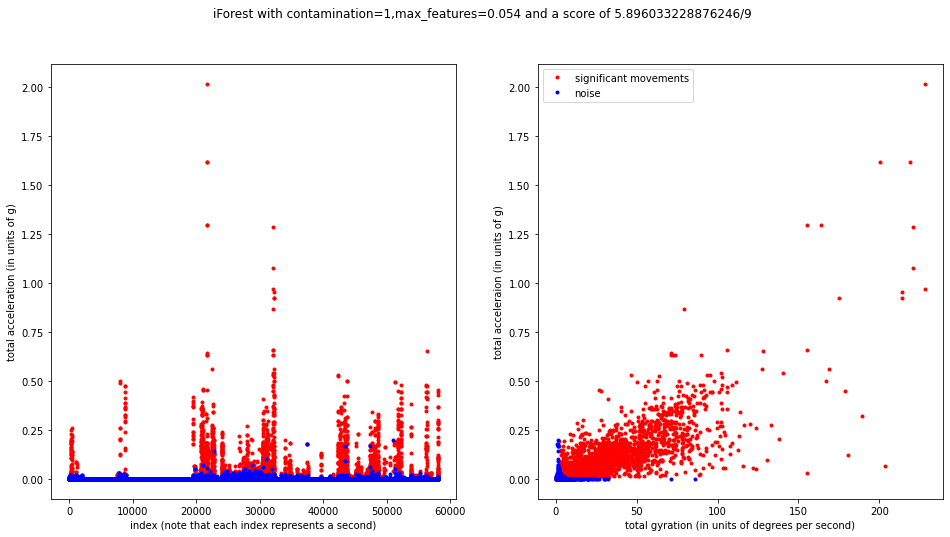

In [11]:
# check visually

iForest = IsolationForest(n_estimators = 100, max_features = parameters[0],\
                          contamination = parameters[1], random_state = 0).fit(X_train)
with open ('/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Models/iForest.pkl',"wb") as f:
    pickle.dump(iForest,f)
output = iForest.predict(X_train)
true_false = []
                
for item in output:
    if item == 1:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]
                
plt.figure(figsize = (16,8))
plt.suptitle('iForest with contamination={},max_features={} and a score of {}/9'.format(*parameters))            

plt.subplot(121)
plt.plot(anomalies.index,anomalies.accTotal,'r.')
plt.plot(actuals.index,actuals.accTotal,'b.')
plt.xlabel('index (note that each index represents a second)')
plt.ylabel('total acceleration (in units of g)')

plt.subplot(122)
plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])

plt.show()

In [12]:
print('percentage decrease:',1-anomalies.shape[0]/df.shape[0])

percentage decrease: 0.9459985195641322


In [13]:
anomalies.shape

(3137, 10)

## Conclusion

- I'm happier with this result. I was a bit dubious of the 0.074 contamination score that we had previously. I would however like to test this on out of sample data to ensure thst the accuracy does not drop too badly

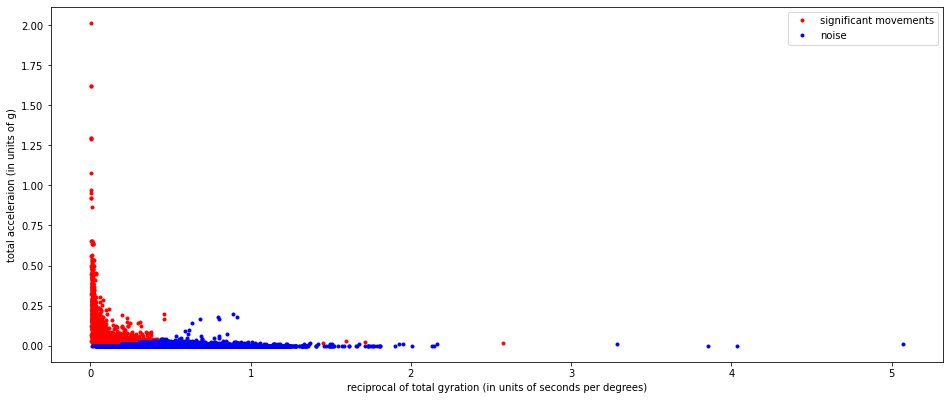

Text(0.5, 1.0, 'this is a scatter plot only for non-significant movements')

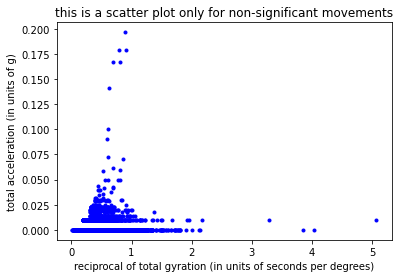

In [16]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)
plt.plot(1/(anomalies.gyrTotal),(anomalies.accTotal),'r.')
plt.plot(1/(actuals.gyrTotal),(actuals.accTotal),'b.')
plt.xlabel('reciprocal of total gyration (in units of seconds per degrees)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])
ax.set_aspect('equal', adjustable='box')
plt.show()

df_new = df_new = pd.DataFrame(data = {'x':1/(actuals.gyrTotal),'y':(actuals.accTotal)})
df_new.reset_index(inplace = True,drop = True)

#df_new = df_new[(df_new.y != 0)]
plt.plot(df_new.x,df_new.y,'b.')
plt.xlabel('reciprocal of total gyration (in units of seconds per degrees)')
plt.ylabel('total acceleration (in units of g)')
plt.title('this is a scatter plot only for non-significant movements')

In [17]:
def convert_to_hist(df,nbins = 100,normalise = True):
    """ converts a scatter plot into a histogram. Note that for this to work best, your scatter plot must 'look'
    like a distribution that could be turned into a histogram, i.e. it must have some sort of hump.
    Components:
    df: the data that you are feeding the function. Must have two columns, x and y for the axes respectively
    nbins: number of bins to segement the data into
    normalise (optional): normalises the resulting histogram
    """
    x_values = []
    y_values = []
    x_unique = df.x.unique()
    x_max = df.x.max()
    x_min = df.x.min()
    x_values.append(x_min)
    print(x_min)
    y_values.append(df.y[df.x == x_min].tolist()[0])
    bins = np.linspace(x_min,x_max,nbins)
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(111)
    for i in range(len(bins) - 1):
        y = df.y[(df.x > bins[i]) & (df.x < bins[i+1])]
        y_max = y.max()
        x_mid = (bins[i]+bins[i+1])/2
        y_values.append(y_max)
        x_values.append(x_mid)
        plt.plot(x_mid,y_max,'r.')
        """
        y_max = y.max()
        plt.plot(x,y_max,'.')
        """
    ax.set_aspect('equal')
    return x_values,y_values

0.011589485922611904
[0.011589485922611904, 0.0371380302645883, 0.0882351189485411, 0.1393322076324939, 0.1904292963164467, 0.24152638500039947, 0.29262347368435226, 0.34372056236830506, 0.39481765105225786, 0.44591473973621065, 0.49701182842016345, 0.5481089171041162, 0.599206005788069, 0.6503030944720218, 0.7014001831559746] [0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.024494897427831782, 0.03162277660168379, 0.04358898943540673, 0.04, 0.05830951894845301, 0.1004987562112089, 0.1407124727947029, 0.1664331697709324]


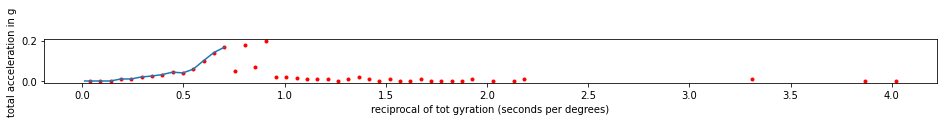

In [23]:
x,y = convert_to_hist(df_new)
#plt.plot(1/(anomalies.gyrTotal),(anomalies.accTotal),'b.')
x = x[0:15]
y = y[0:15]
plt.plot(x,y)
plt.xlabel('reciprocal of tot gyration (seconds per degrees)')
plt.ylabel('total acceleration in g')
print(x,y)

[ 0.77416974 -0.15839742  0.09528795 -0.00427987]


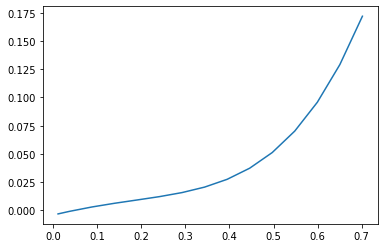

In [25]:
from scipy.optimize import curve_fit

def func(x,a,b,c,d):
    x = np.asarray(x)
    return d+c*x + b*(np.power(x,2)) + a*(np.power(x,4))

popt, pcov = curve_fit(func, x, y)
plt.plot(x, func(x, *popt))
print(popt)

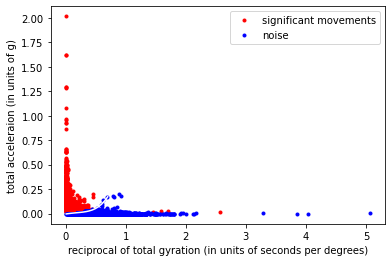

In [26]:
plt.plot(1/(anomalies.gyrTotal),(anomalies.accTotal),'r.')
plt.plot(1/(actuals.gyrTotal),(actuals.accTotal),'b.')
plt.plot(x,func(x,*popt),'white')
plt.xlabel('reciprocal of total gyration (in units of seconds per degrees)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])

In [88]:
print('the equation is:\n x^4:  {}\n x^2:  {}\n x:  {}\n constant:  {}'.format(*popt))

the equation is:
 x^4:  0.7741697399557282
 x^2:  -0.15839741967042406
 x:  0.09528795099596377
 constant:  -0.004279871380772796


## Notes:

- the fit is good, I'm somewhat happy with this???
- Would like to cross check it though, remember to check how robust your equation is. Compare this with the old data and get an accuracy percentage, as well as with that of the new data that Rohan will generate